In [4]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, make_scorer, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm
from dataprep import *
import anndata as ad

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

In [6]:
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")


In [110]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [7]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [8]:
adata.obs['random_or_pattern'] = adata.obs['random_or_pattern'].replace('random','no_pattern')
adata.obs['pattern'] = adata.obs['pattern'].replace('random','no_pattern')

In [9]:
adata_strong = adata[adata.obs['pattern_strength']=='strong']

In [10]:
def balanceTrainingData_pattern_noPattern(adata, random_seed: int = 101):
    """
    Downsample the anndata object so that the test and control group for RF are equal size, while the control group is balanced for patterns and spot count. 
    Assumes there are less test observations than the other subcellular expression patterns combined. 

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    random_seed: int
        Seed for reproducability purposes. 
        
    Returns
    -------
    balanced_adata : ad.AnnData
        test and control group are equal size, while the control group is balanced for patterns and spot count
    """
        
    adata_test = adata[adata.obs['random_or_pattern']=='pattern']
    adata_control = adata[adata.obs['random_or_pattern']=='no_pattern']
    
    sample_size = len(adata_control)
    
    subset = adata_test.obs['n_spots_interval'].sample(n=sample_size, random_state=random_seed)
    
    adata_test_subset = adata_test[adata_test.obs.index.isin(subset.index)]
    
    # Concatenate adata_test and adata_control_subset
    adata = ad.concat([adata_test_subset, adata_control])

    return adata

In [8]:
def balanceTrainingData_pattern_noPattern_prev_version(adata, random_seed: int = 101):
    """
    Downsample the anndata object so that the test and control group for RF are equal size, while the control group is balanced for patterns and spot count. 
    Assumes there are less test observations than the other subcellular expression patterns combined. 

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    random_seed: int
        Seed for reproducability purposes. 
        
    Returns
    -------
    balanced_adata : ad.AnnData
        test and control group are equal size, while the control group is balanced for patterns and spot count
    """
        
    adata_test = adata[adata.obs['random_or_pattern']=='pattern']
    adata_control = adata[adata.obs['random_or_pattern']=='no_pattern']
    
    sample_size = len(adata_control)

    # Calculate the proportions of each interval and use that as probability weights to draw each interval.
    ratios = adata_test.obs['n_spots_interval'].value_counts(normalize=True)
    # Ensure that the weights Series has the same index as adata_test.obs['n_spots_interval']
    proportions = adata_test.obs['n_spots_interval'].map(ratios).fillna(1)
    
    subset = adata_test.obs['n_spots_interval'].sample(n=sample_size, weights=proportions, random_state=random_seed)
    
    adata_test_subset = adata_test[adata_test.obs.index.isin(subset.index)]
    
    # Concatenate adata_test and adata_control_subset
    adata = ad.concat([adata_test_subset, adata_control])

    return adata

In [97]:
adata_train.obs['random_or_pattern'].value_counts()

pattern       382233
no_pattern     50344
Name: random_or_pattern, dtype: int64

In [95]:
test = adata_train[adata_train.obs['random_or_pattern']=='pattern']
test.obs['n_spots_interval'].value_counts(normalize=True)

100+      0.412228
90-100    0.069002
80-90     0.068971
10-20     0.068835
70-80     0.068785
20-30     0.068558
40-50     0.068087
50-60     0.067310
30-40     0.066857
0-10      0.041367
Name: n_spots_interval, dtype: float64

In [11]:
def balanceTrainingData(adata, testPattern: str = 'pericellular', include_random: bool = False, random_seed: int = 101):
    """
    Downsample the anndata object so that the test and control group for RF are equal size, while the control group is balanced for patterns and spot count. 
    Assumes there are less test observations than the other subcellular expression patterns combined. 

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    testPattern : str
        Type of subcellular expression pattern you want to use as the test case. All other patterns will be used as control. 
    pattern_no_pattern: bool
        True: test pattern or no pattern, False: test patterns versus other patterns. Default is False.
    include_random: bool
        Whether the `no_pattern` pattern is included in the data or not. Default is False. 
    random_seed: int
        Seed for reproducability purposes. 
        
    Returns
    -------
    balanced_adata : ad.AnnData
        test and control group are equal size, while the control group is balanced for patterns and spot count
    """

    if include_random == False:
        adata = adata[adata.obs['pattern']!='no_pattern'].copy()

    adata_test = adata[adata.obs['pattern']==testPattern]
    adata_control = adata[adata.obs['pattern']!=testPattern]

    sample_size = int(len(adata_test)/len(adata_control.obs['pattern'].unique()))
    pattern_groups = adata_control.obs.groupby('pattern')
    subset_obs_list = []

    # loop over group patterns, for each pattern, group by n_spots_interval. In those interval groups, sample `target_samplesize`. 
    for pattern, group in pattern_groups:
        subset = group['n_spots_interval'].sample(n=sample_size, random_state=random_seed)
        subset_obs_list.append(subset)
    
    # Concatenate all subset observations and use these indices to subset the adata_control AnnData object
    all_subset_obs = pd.concat(subset_obs_list)
    adata_control_subset = adata_control[adata_control.obs.index.isin(all_subset_obs.index)]
    
    # Concatenate adata_test and adata_control_subset
    adata = ad.concat([adata_test, adata_control_subset])
    adata.obs[testPattern] = np.where(adata.obs["pattern"] == testPattern, testPattern, "other")

    return adata

In [ ]:
adata_train = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['train_cellIDs'])]
adata_test = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['test_cellIDs'])]

# Random Forest

## Pattern / no pattern

In [32]:
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train)
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test)

In [43]:
adata_train_balanced_pattern = balanceTrainingData(adata_train, testPattern = 'pericellular', include_random = False, random_seed = seed)
adata_test_balanced_pattern = balanceTrainingData(adata_test, testPattern = 'pericellular', include_random = False, random_seed = seed)

In [40]:
adata_train_balanced_pattern.obs['pattern'].value_counts()

pericellular    50320
cell-edge        6290
extranuclear     6290
foci             6290
intranuclear     6290
nuclear-edge     6290
perinuclear      6290
protrusion       6290
no_pattern       6290
Name: pattern, dtype: int64

In [45]:
# Create a random forest classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed, max_features='sqrt', bootstrap=True, oob_score=True)
rf_classifier.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

#out of bag score during training
rf_classifier.oob_score_

0.9600394842999049

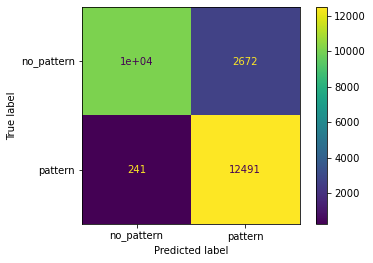

In [46]:
test_extranuclear = rf_classifier.predict(adata_test_balanced.obsm["latent"])

confusion_matrix = metrics.confusion_matrix(adata_test_balanced.obs["random_or_pattern"], test_extranuclear, labels = rf_classifier.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_classifier.classes_) 
cm_display.plot()
plt.show()

In [ ]:
print("f1 score: ", fbeta_score(adata_test_balanced.obs["random_or_pattern"], test_extranuclear, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_extranuclear, pos_label='no_pattern'))

f1 score:  0.8955726832765729
inverted f1 score:  0.8735292840706812


Make random the desired pattern to score on, so that the F1 will be selecting for the best true negative. 

In [58]:
adata_train_labels = adata_train_balanced.copy()
pattern_mapping = {'pattern': 1, 'no_pattern': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [59]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5]}
f_scorer_precision = make_scorer(fbeta_score, beta=0.5) # 0.5 -> precision 2x as important as recall, when scoring on TP, FP is punished harder than FN. 

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='roc_auc', verbose=3, error_score='raise', n_jobs = 5)
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'mean_fit_time': array([16.5635808 , 24.51412659, 32.49194579, 40.33258028]), 'std_fit_time': array([0.63372168, 1.0884875 , 1.53532241, 1.95497825]), 'mean_score_time': array([0.19381657, 0.18845201, 0.18224463, 0.17917776]), 'std_score_time': array([0.01779801, 0.01738824, 0.01672054, 0.01573796]), 'param_max_features': masked_array(data=[2, 3, 4, 5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}], 'split0_test_score': array([0.91063477, 0.91094238, 0.91035068, 0.90996012]), 'split1_test_score': array([0.98084836, 0.98101615, 0.98030512, 0.980007  ]), 'split2_test_score': array([0.98391185, 0.9842472 , 0.98443334, 0.98437324]), 'split3_test_score': array([0.98720169, 0.98783447, 0.98791014, 0.98887897]), 'split4_test_score': array([0.98554207, 0.98510281, 0.98571303, 0.98526644]),

In [60]:
adata_train_labels = adata_train_balanced.copy()
pattern_mapping = {'pattern': 0, 'no_pattern': 1}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [57]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5]}
f_scorer_precision = make_scorer(fbeta_score, beta=2) # 0.5 -> precision 2x as important as recall, when scoring on TP, FP is punished harder than FN. But now it is reversed because we say that random is the TP, so we want to reduce FN. 

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='roc_auc', verbose=3, error_score='raise', n_jobs = 5)
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'mean_fit_time': array([16.51269259, 24.32979774, 32.24488626, 40.18910041]), 'std_fit_time': array([0.63910487, 1.09279731, 1.51370771, 1.89662738]), 'mean_score_time': array([0.19818406, 0.1882648 , 0.18411303, 0.18080006]), 'std_score_time': array([0.02142343, 0.01743964, 0.01668881, 0.01574771]), 'param_max_features': masked_array(data=[2, 3, 4, 5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}], 'split0_test_score': array([0.89824522, 0.89993417, 0.89827226, 0.89900528]), 'split1_test_score': array([0.94075834, 0.94260204, 0.94130448, 0.94026809]), 'split2_test_score': array([0.92989843, 0.93069663, 0.93046688, 0.93186853]), 'split3_test_score': array([0.93373011, 0.9358412 , 0.93530225, 0.93462533]), 'split4_test_score': array([0.93932916, 0.93874209, 0.93914155, 0.93874169]), 'mean_test_score': array([0.92839225, 0.92956322, 0.9288974

### Old model, new embeddings, inverted f1 score for scoring

In [69]:
train_accuracy = []
test_accuracy = []
for count in tqdm(range(50, 401, 50)):
    # create random forest classifier and fit on training data
    rf_classifier = RandomForestClassifier(n_estimators=count, random_state=seed, max_features=3, bootstrap=True, oob_score=True, n_jobs = 4)
    rf_classifier.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
    #predict label
    train_pred = rf_classifier.predict_proba(adata_train_balanced.obsm["latent"])[:,1]
    test_pred = rf_classifier.predict_proba(adata_test_balanced.obsm["latent"])[:,1]

    # Obtain training and validation F1 score. 
    train_f1 = roc_auc_score(adata_train_balanced.obs["random_or_pattern"], train_pred)
    test_f1 = roc_auc_score(adata_test_balanced.obs["random_or_pattern"], test_pred)

    #append scores to lists
    train_accuracy.append(train_f1)
    test_accuracy.append(test_f1)

100%|██████████| 8/8 [02:40<00:00, 20.00s/it]


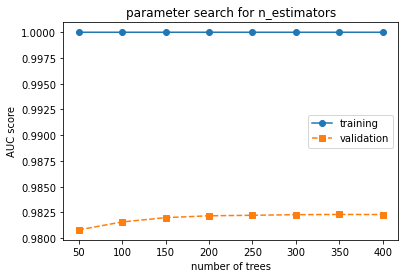

In [70]:
plt.figure()

x_values = range(50, 401, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o')
plt.plot(x_values, test_accuracy, label='validation', linestyle='--', marker='s')

# Add labels and legend
plt.title('parameter search for n_estimators')
plt.xlabel('number of trees')
plt.ylabel('AUC score')
plt.legend()
plt.show()

In [71]:
test_accuracy

[0.9808025904435174,
 0.9815762335131588,
 0.9819935987444689,
 0.9821746462933534,
 0.9822240559852554,
 0.9822836906055962,
 0.9823046031289182,
 0.9822966329282894]

There is hardly any improvement with more trees in the random forest, will chose 200

In [14]:
# create random forest classifier and fit on training data
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_classifier.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

In [30]:
adata_test.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,prop_interval,corresponding_dapis,train_or_val,original_image_paths,pattern_strength
0,cell-edge,pattern,100,100+,106,blank,210,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1,cell-edge,pattern,100,100+,106,blank,219,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
2,cell-edge,pattern,100,100+,106,blank,226,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
3,cell-edge,pattern,100,100+,106,blank,316,300+,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
4,cell-edge,pattern,100,100+,106,blank,73,60-120,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627117,no_pattern,no_pattern,99,100+,240,blank,101,60-120,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1627118,no_pattern,no_pattern,99,100+,240,blank,190,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1627119,no_pattern,no_pattern,99,100+,240,blank,250,240-300,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1627120,no_pattern,no_pattern,99,100+,240,blank,251,240-300,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong


In [31]:
test_pred_balanced = rf_classifier.predict(adata_test.obsm["latent"])
test_pred_unbalanced = rf_unbalanced.predict(adata_test.obsm["latent"])

print("balanced")
print("f1 score: ", f1_score(adata_test.obs["random_or_pattern"], test_pred_balanced, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test.obs["random_or_pattern"], test_pred_balanced, pos_label='pattern'))

print("unbalanced")
print("f1 score: ", f1_score(adata_test.obs["random_or_pattern"], test_pred_unbalanced, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test.obs["random_or_pattern"], test_pred_unbalanced, pos_label='pattern'))

balanced
f1 score:  0.6823750204847648
inverted f1 score:  0.6823750204847648
unbalanced
f1 score:  0.7896140339527201
inverted f1 score:  0.7896140339527201


In [34]:
test_pred_balanced = rf_classifier.predict(adata_test_balanced.obsm["latent"])
test_pred_unbalanced = rf_unbalanced.predict(adata_test_balanced.obsm["latent"])

print("balanced")
print("f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_balanced, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_balanced, pos_label='pattern'))

print("unbalanced")
print("f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_unbalanced, pos_label='pattern'))
print("inverted f1 score: ", f1_score(adata_test_balanced.obs["random_or_pattern"], test_pred_unbalanced, pos_label='pattern'))

balanced


f1 score:  0.6587327860169492
inverted f1 score:  0.6587327860169492
unbalanced
f1 score:  0.7123070944820694
inverted f1 score:  0.7123070944820694


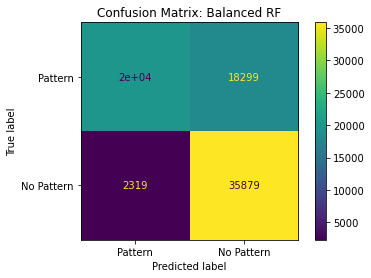

In [43]:
confusion_matrix = metrics.confusion_matrix(adata_test_balanced.obs["random_or_pattern"], test_pred_balanced, labels = ["pattern", "no_pattern"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pattern", "No Pattern"]) 
cm_display.plot()
plt.title("Confusion Matrix: Balanced RF")
plt.show()

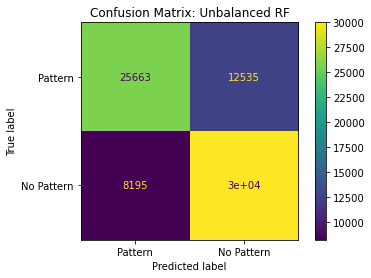

In [44]:
confusion_matrix = metrics.confusion_matrix(adata_test_balanced.obs["random_or_pattern"], test_pred_unbalanced, labels = ["pattern", "no_pattern"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pattern", "No Pattern"]) 
cm_display.plot()
plt.title("Confusion Matrix: Unbalanced RF")
plt.show()

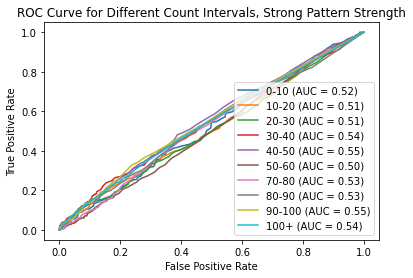

In [137]:
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_balanced[adata_test_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_classifier.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['random_or_pattern'],
        test_pred, 
        pos_label = "pattern",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve for Different Count Intervals, Strong Pattern Strength")
ax.plot(np.arange(0,1,5),np.arange(0,1,5))

plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [18]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

In [1]:
import pickle

path = f"temp_objects/rf_pattern_noPattern.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    rf_unbalanced = pickle.load(p)

In [16]:
adata_test_balanced

AnnData object with n_obs × n_vars = 25464 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    obsm: 'latent'

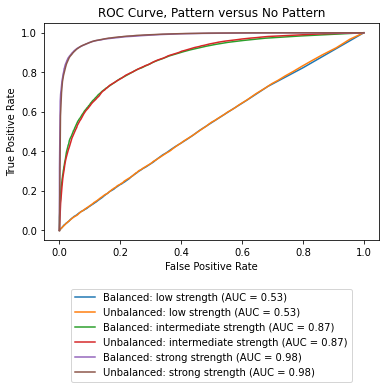

In [21]:
pattern_strength = ["low", "intermediate", "strong"]
models= {"Balanced: ": rf_classifier,"Unbalanced: ": rf_unbalanced}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = adata_test_balanced[adata_test_balanced.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['random_or_pattern'],
            test_pred, 
            pos_label = "pattern",
            name = f"{name}{strength} strength",
            ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Pattern versus No Pattern"
    )

plt.legend(bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [221]:
pattern_strength = ["low", "intermediate", "strong"]
models= {"Balanced: ": rf_classifier,"Unbalanced: ": rf_unbalanced}
model = rf_unbalanced

adata_test_strength = adata_test[adata_test.obs["pattern_strength"]=="strong"]
test_pred = model.predict(adata_test_strength.obsm["latent"])

In [89]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

In [91]:
adata_test.obs["pattern_strength"].unique()

array(['strong', 'intermediate', 'low'], dtype=object)

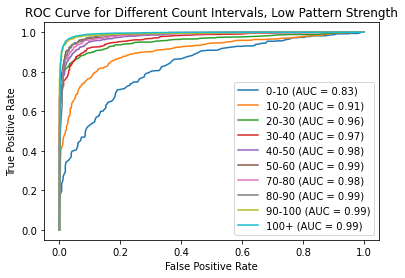

In [147]:
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test_strength)
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_balanced[adata_test_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_classifier.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['random_or_pattern'],
        test_pred, 
        pos_label = "pattern",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve for Different Count Intervals, Low Pattern Strength")

plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

## Test RF pattern no pattern, on strong + intermediate data

In [96]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

adata_train_strength = adata_train[adata_train.obs["pattern_strength"]!="low"]
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train_strength)
adata_test_strength = adata_test[adata_test.obs["pattern_strength"]=="low"]
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test_strength)

In [97]:
# create random forest classifier and fit on training data
rf_mixed_strength = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_mixed_strength.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) 

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

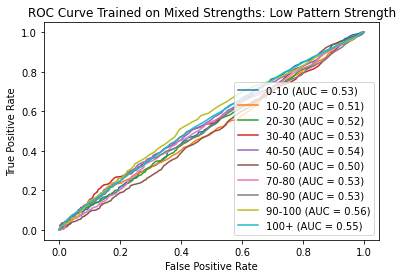

In [102]:
adata_test_strength = adata_test[adata_test.obs["pattern_strength"]=="low"]
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test_strength)
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_balanced[adata_test_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_mixed_strength.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['random_or_pattern'],
        test_pred, 
        pos_label = "pattern",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve Trained on Mixed Strengths: Low Pattern Strength")


plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [81]:
import pickle

In [103]:
rf_pattern_mixed_trained = rf_classifier
path = f"temp_objects/rf_balanced/rf_intermediate_strong_trained.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_pattern_mixed_trained, f)

## Random Forest - Separate Binary classifiers

In [159]:
adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

In [130]:
adata_train = adata_train[adata_train.obs['pattern_strength']=="strong"]
adata_test = adata_test[adata_test.obs['pattern_strength']=="strong"]

In [131]:
adata_train_balanced_pattern = balanceTrainingData(adata_train, testPattern = 'pericellular', include_random = False, random_seed = seed)
adata_test_balanced_pattern = balanceTrainingData(adata_test, testPattern = 'pericellular', include_random = False, random_seed = seed)

In [160]:
patterns = adata_train[adata_train.obs['pattern']!='random'].obs['pattern'].unique()
train_data = {}
test_data = {}

for pattern in patterns:
    adata_train.obs[pattern] = np.where(adata_train.obs["pattern"] == pattern, pattern, "other")
    adata_test.obs[pattern] = np.where(adata_test.obs["pattern"] == pattern, pattern, "other")
    train_data[pattern] = balanceTrainingData(adata_train, testPattern = pattern, include_random = False, random_seed = seed)
    test_data[pattern] = balanceTrainingData(adata_test, testPattern = pattern, include_random = False, random_seed = seed)


<ipython-input-160-5838ec59b7fa>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs[pattern] = np.where(adata_train.obs["pattern"] == pattern, pattern, "other")
<ipython-input-160-5838ec59b7fa>:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs[pattern] = np.where(adata_test.obs["pattern"] == pattern, pattern, "other")


f1 score:  0.9621432267823734
inverted f1 score:  0.9630837312216141


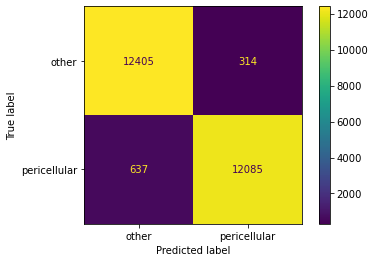

In [134]:
 # create random forest classifier EXCLUDING random
rf_pericellular = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_pericellular.fit(train_data['pericellular'].obsm["latent"], train_data['pericellular'].obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular.predict(test_data['pericellular'].obsm["latent"])

print("f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(test_data['pericellular'].obs["pericellular"], test_pericellular, labels = rf_pericellular.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_pericellular.classes_) 
cm_display.plot()
plt.show()

In [127]:
import pickle

path = "temp_objects/f1_negative_cellID_split/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    peri_model_splitID = pickle.load(p)

f1 score:  0.9291549708827349
inverted f1 score:  0.937400510865139


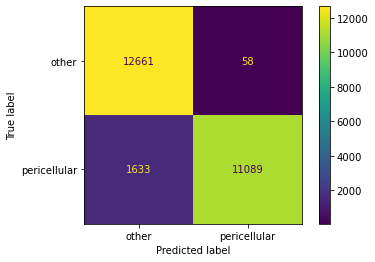

In [135]:
test_pericellular_old = peri_model_splitID.predict(test_data['pericellular'].obsm["latent"])

print("f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular_old, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular_old, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(test_data['pericellular'].obs["pericellular"], test_pericellular_old, labels = peri_model_splitID.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = peri_model_splitID.classes_) 
cm_display.plot()
plt.show()

In [158]:
adata_test_balanced.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,prop_interval,corresponding_dapis,train_or_val,original_image_paths,pattern_strength
46,cell-edge,pattern,101,100+,182,blank,117,60-120,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
47,cell-edge,pattern,101,100+,182,blank,15,0-60,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
110,cell-edge,pattern,102,100+,212,blank,254,240-300,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
126,cell-edge,pattern,102,100+,48,blank,168,120-180,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
400,cell-edge,pattern,10,0-10,183,blank,250,240-300,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627102,no_pattern,no_pattern,99,100+,106,blank,189,180-240,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
1627103,no_pattern,no_pattern,99,100+,106,blank,230,180-240,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low
1627104,no_pattern,no_pattern,99,100+,106,blank,272,240-300,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,low
1627105,no_pattern,no_pattern,99,100+,106,blank,340,300+,1.5,0.1,0-0.1,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,low


In [164]:
test_peri = test_data['pericellular']
adata_test_strength = test_peri[test_peri.obs["pattern_strength"]=="low"]
adata_test_balanced.obs['n_spots_interval'].value_counts()

Series([], Name: n_spots_interval, dtype: int64)

In [176]:
models= {"Balanced: ": rf_pericellular,"Unbalanced: ": peri_model_splitID}
models

{'Balanced: ': RandomForestClassifier(max_features=3, n_estimators=150, n_jobs=4,
                        random_state=101),
 'Unbalanced: ': RandomForestClassifier(max_features=3, n_estimators=150, random_state=101)}

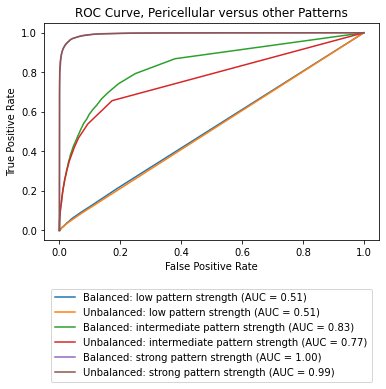

In [192]:
test_peri = test_data['pericellular']
pattern_strength = ["low", "intermediate", "strong"]

models= {"Balanced: ": rf_pericellular,"Unbalanced: ": peri_model_splitID}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = test_peri[test_peri.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = f"{name}{strength} pattern strength",
            ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Pericellular versus other Patterns"
    )

plt.legend(bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

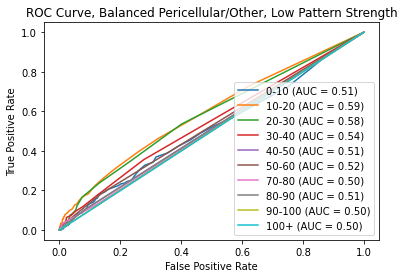

In [ ]:
test_peri = test_data['pericellular']
adata_test_strength = test_peri[test_peri.obs["pattern_strength"]=="low"]
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_strength[adata_test_strength.obs['n_spots_interval']==interval]
    test_pred = rf_pericellular.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['pericellular'],
        test_pred, 
        pos_label = "pericellular",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Balanced Pericellular/Other, Low Pattern Strength")


plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

## Saving and restoring RF objects

In [ ]:
import pickle
patterns = {'cellEdge': rf_cellEdge, 'foci': rf_foci, 'extranuclear': rf_extranuclear, 'intranuclear': rf_intranuclear, 'nuclearEdge': rf_nuclearEdge, 'pericellular': rf_pericellular, 'perinuclear': rf_perinuclear, 'protrusion': rf_protrusion}

for key, value in patterns.items():
    path = f"temp_objects/f1_negative_cellID_split/rf_{key}.pkl"

    # Open the file in write-binary mode and dump the object
    with open(path, 'wb') as f:
        pickle.dump(value, f)

In [7]:
import pickle

patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
models = {}

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/f1_negative_cellID_split/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        models[pattern] = pickle.load(p)

# 1 gene n cells

### F1 exploration

In [9]:
counts = adata.obs['n_spots_interval'].unique()
pattern_strength = adata.obs['pattern_strength'].unique()

In [13]:
for count in counts:
    adata_count = adata[adata.obs['n_spots_interval']==count]
    rf_score = models['pattern'].predict(adata_count.obsm["latent"])

    print(f"f1 score for {count}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))
    print(f"inverse f1 score for {count}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='no_pattern'))

    confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = models['pattern'].classes_)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = models['pattern'].classes_) 
    cm_display.plot()
    plt.savefig(f'images/confusion_matrix/pattern_nopattern/total/new_embeddings/pattern_{count}.png')
    plt.close()

f1 score for 100+:  0.7695910665356976
inverse f1 score for 100+:  0.40117378966377154
f1 score for 0-10:  0.9303119433282241
inverse f1 score for 0-10:  0.4078845476944738
f1 score for 10-20:  0.870513692345887
inverse f1 score for 10-20:  0.36786636454655636
f1 score for 20-30:  0.8394893152181335
inverse f1 score for 20-30:  0.37412370219185376
f1 score for 30-40:  0.8149536397711581
inverse f1 score for 30-40:  0.37749843847595255
f1 score for 40-50:  0.8052834056993385
inverse f1 score for 40-50:  0.39768192006997977
f1 score for 50-60:  0.7918112171147731
inverse f1 score for 50-60:  0.384530465439265
f1 score for 70-80:  0.786311796392874
inverse f1 score for 70-80:  0.38542749881030014
f1 score for 80-90:  0.7794282784884289
inverse f1 score for 80-90:  0.38072718549741275
f1 score for 90-100:  0.776207548559782
inverse f1 score for 90-100:  0.3988258187934958


In [16]:
adata[adata.obs['pattern']=='random'].obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,prop,prop_interval,corresponding_dapis,train_or_val,original_image_paths,pattern_strength
1437959,random,random,100,100+,151,blank,138,120-180,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437960,random,random,100,100+,151,blank,168,120-180,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437961,random,random,100,100+,151,blank,186,180-240,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437962,random,random,100,100+,151,blank,309,300+,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
1437963,random,random,100,100+,151,blank,97,60-120,1.5,0.9,0.8-0.9,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,strong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627147,random,random,9,0-10,308,blank,154,120-180,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate
1627148,random,random,9,0-10,308,blank,168,120-180,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate
1627149,random,random,9,0-10,308,blank,230,180-240,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,train,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate
1627150,random,random,9,0-10,308,blank,281,240-300,1.5,0.5,0.4-0.5,/mnt/data/david/simulated_cells/with_dapi/cust...,val,/mnt/data/david/simulated_cells/with_dapi/cust...,intermediate


In [47]:
for strength in pattern_strength:
    for count in counts:

        adata_count = adata[(adata.obs['n_spots_interval']==count)&(((adata.obs['pattern_strength']==strength) & (adata.obs['random_or_pattern']=='pattern'))|(adata.obs['random_or_pattern']=='random'))]
        rf_score = models['pattern'].predict(adata_count.obsm["latent"])

        print(f"f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))
        print(f"inverse f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random'))

        confusion_matrix = metrics.confusion_matrix(adata_count.obs["random_or_pattern"],rf_score, labels = models['pattern'].classes_)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Pattern', 'No Pattern']) 
        cm_display.plot()
        plt.savefig(f'images/confusion_matrix/pattern_{strength}_{count}.png')
        plt.close()

f1 score for 0-10 & strong:  0.882816202188875
inverse f1 score for 0-10 & strong:  0.5273505051424411


f1 score for 10-20 & strong:  0.911378009541773
inverse f1 score for 10-20 & strong:  0.6860259433962265
f1 score for 20-30 & strong:  0.9365355543512365
inverse f1 score for 20-30 & strong:  0.7912170404429015
f1 score for 30-40 & strong:  0.9480544430815612
inverse f1 score for 30-40 & strong:  0.8462043316560927
f1 score for 40-50 & strong:  0.9639294620591378
inverse f1 score for 40-50 & strong:  0.8998020781791192
f1 score for 50-60 & strong:  0.9703899238253262
inverse f1 score for 50-60 & strong:  0.9166772783225096
f1 score for 70-80 & strong:  0.9766690595836325
inverse f1 score for 70-80 & strong:  0.9334130100734164
f1 score for 80-90 & strong:  0.9808027403380744
inverse f1 score for 80-90 & strong:  0.9451699349185418
f1 score for 90-100 & strong:  0.9843268708099293
inverse f1 score for 90-100 & strong:  0.9588454523828404
f1 score for 100+ & strong:  0.9886345149333112
inverse f1 score for 100+ & strong:  0.9704802085432527
f1 score for 0-10 & intermediate:  0.8523373052

In [ ]:
adata.obs['n_spots_interval'].unique()

['100+', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '70-80', '80-90', '90-100']
Categories (10, object): ['0-10' < '10-20' < '20-30' < '30-40' ... '70-80' < '80-90' < '90-100' < '100+']

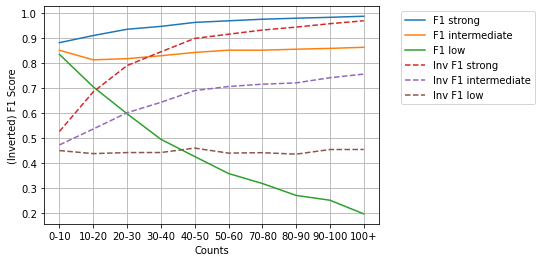

In [33]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the F1 scores
pattern_strength = ['strong', 'intermediate', 'low']
f1_scores = {strength: [] for strength in pattern_strength}
inv_f1_scores = {strength: [] for strength in pattern_strength}
counts = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '70-80', '80-90', '90-100', '100+']

for strength in pattern_strength:
    for count in counts:
        adata_count = adata[(adata.obs['n_spots_interval'] == count) & (((adata.obs['pattern_strength'] == strength) & (adata.obs['random_or_pattern'] == 'pattern')) | (adata.obs['random_or_pattern'] == 'random'))]
        rf_score = models['pattern'].predict(adata_count.obsm["latent"])
        f1 = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern')
        inv_f1 = f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random')
        f1_scores[strength].append(f1)
        inv_f1_scores[strength].append(inv_f1)

# Create the plot
for strength, scores in f1_scores.items():
    plt.plot(counts, scores, label=f'F1 {strength}')
for strength, scores in inv_f1_scores.items():
    plt.plot(counts, scores, linestyle='--', label=f'Inv F1 {strength}')

plt.xlabel('Counts')
plt.ylabel('(Inverted) F1 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True) 
plt.show()

In [ ]:
f1 = {}
inv_f1 = {}
for strength in pattern_strength:
    for count in counts:

        adata_count = adata[(adata.obs['n_spots_interval']==count)&(((adata.obs['pattern_strength']==strength) & (adata.obs['random_or_pattern']=='pattern'))|(adata.obs['random_or_pattern']=='random'))]
        rf_score = models['pattern'].predict(adata_count.obsm["latent"])

        print(f"f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='pattern'))
        print(f"inverse f1 score for {count} & {strength}: ", f1_score(adata_count.obs["random_or_pattern"], rf_score, pos_label='random'))


f1 score for 100+ & strong:  0.9886345149333112
inverse f1 score for 100+ & strong:  0.9704802085432527
f1 score for 0-10 & strong:  0.882816202188875
inverse f1 score for 0-10 & strong:  0.5273505051424411
f1 score for 10-20 & strong:  0.911378009541773
inverse f1 score for 10-20 & strong:  0.6860259433962265
f1 score for 20-30 & strong:  0.9365355543512365
inverse f1 score for 20-30 & strong:  0.7912170404429015
f1 score for 30-40 & strong:  0.9480544430815612
inverse f1 score for 30-40 & strong:  0.8462043316560927
f1 score for 40-50 & strong:  0.9639294620591378
inverse f1 score for 40-50 & strong:  0.8998020781791192
f1 score for 50-60 & strong:  0.9703899238253262
inverse f1 score for 50-60 & strong:  0.9166772783225096
f1 score for 70-80 & strong:  0.9766690595836325
inverse f1 score for 70-80 & strong:  0.9334130100734164
f1 score for 80-90 & strong:  0.9808027403380744
inverse f1 score for 80-90 & strong:  0.9451699349185418
f1 score for 90-100 & strong:  0.9843268708099293
in

### Statistics 1 gene n cells

In [71]:
pericellular_dict_low = subsetGenes(adata, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')
pericellular_dict_high = subsetGenes(adata, 'pericellular', pattern_strength=0.9, count_threshold = 100, high_or_low = 'high')
random_dict_low = subsetGenes(adata, 'random', count_threshold = 11, high_or_low = 'low', mixed_counts=False)
random_dict_high = subsetGenes(adata, 'random', count_threshold = 100, high_or_low = 'high', mixed_counts=False)
pattern_dict_low = subsetGenes(adata, mixed_patterns = True, pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')
pattern_dict_high = subsetGenes(adata, mixed_patterns = True, pattern_strength = 0.9, count_threshold = 100, high_or_low = 'high')

In [105]:
rows = []
patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
gene_id = np.array(range(10))

for pattern in patterns:
    for i in range(10):
        pericellular_low = models.get(pattern).predict_proba(pericellular_dict_low.get(i).obsm["latent"])[:,0]
        pericellular_high = models.get(pattern).predict_proba(pericellular_dict_high.get(i).obsm["latent"])[:,0]
        random_low = models.get(pattern).predict_proba(random_dict_low.get(i).obsm["latent"])[:,0]
        random_high = models.get(pattern).predict_proba(random_dict_high.get(i).obsm["latent"])[:,0]
        pattern_low = models.get(pattern).predict_proba(pattern_dict_low.get(i).obsm["latent"])[:,0]
        pattern_high = models.get(pattern).predict_proba(pattern_dict_high.get(i).obsm["latent"])[:,0]
        for value in pericellular_low:
            rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': pattern, 'gene_id': i})
        for value in pericellular_high: 
            rows.append({'prob_pattern': value, 'group': 'pericellular_high', 'RF_Classifier': pattern, 'gene_id': i})
        for value in random_low:
            rows.append({'prob_pattern': value, 'group': 'random_low', 'RF_Classifier': pattern, 'gene_id': i})
        for value in random_high:
            rows.append({'prob_pattern': value, 'group': 'random_high', 'RF_Classifier': pattern, 'gene_id': i})
        for value in pattern_low:
            rows.append({'prob_pattern': value, 'group': 'pattern_low', 'RF_Classifier': pattern, 'gene_id': i})
        for value in pattern_high:
            rows.append({'prob_pattern': value, 'group': 'pattern_high', 'RF_Classifier': pattern, 'gene_id': i})
df = pd.DataFrame(rows)

In [100]:
test = df[df['group']=='pattern_low']
test = test[test['RF_Classifier']=='pericellular']
test['prob_pattern'].mean()

0.8716908517350158

In [104]:
test = df[df['group']=='pericellular']
test = test[test['RF_Classifier']=='pericellular']
test['prob_pattern'].mean()

0.3252483660130719

In [107]:
df['group'].unique()

array(['pericellular_low', 'pericellular_high', 'random_low',
       'random_high', 'pattern_low', 'pattern_high'], dtype=object)

In [113]:
pericellular_dict_low.get(9).obs['prop'].unique()

array([0.9])

In these graphs the pericellular is wrong because they use the wrong probability in the array from predict_proba. first column is other, second column is pericellular

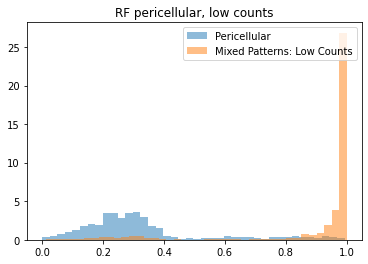

In [62]:
pattern = 'pericellular'
pericellular = df[(df['pattern'] == pattern) & (df['group']=='pericellular')]
pattern_low = df[(df['pattern'] == pattern) & (df['group']=='pattern_low')]
random_low = df[(df['pattern'] == pattern) & (df['group']=='random_low')]

plt.hist(pericellular['prob_pattern'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(pattern_low['prob_pattern'], bins=40, alpha=0.5, label='Mixed Patterns: Low Counts', density=True)
#plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title(f"RF {pattern}, low counts")
plt.legend(loc='upper right')
plt.show()

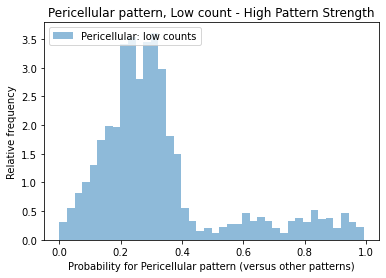

In [108]:
pattern = df[(df['RF_Classifier'] == 'pericellular') & (df['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular pattern, Low count - High Pattern Strength")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## see if I get the old graph if I go with the old data through this RF

In [8]:
adata_all = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")

In [9]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata_all.obs['prop'] == 0.9) | ((adata_all.obs['prop'] == 0.4) & (adata_all.obs['pattern'] == 'protrusion')),
    (adata_all.obs['prop'] == 0.5) | ((adata_all.obs['prop'] == 0.2) & (adata_all.obs['pattern'] == 'protrusion')),
    (adata_all.obs['prop'] == 0.1) | ((adata_all.obs['prop'] == 0.0) & (adata_all.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata_all.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [130]:
pericellular_dict_low_all = subsetGenes(adata_all, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')

In [172]:
import pickle

path = "temp_objects/f1_negative_cellID_split/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    peri_model_splitID = pickle.load(p)

In [175]:
rows = []

for i in range(10):
    pericellular_low_all = peri_model_splitID.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,1]
    for value in pericellular_low_all:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_new_model = pd.DataFrame(rows)

In [140]:
df_all_spots_new_model['prob_pattern'].value_counts()

0.966667    619
0.960000    567
0.973333    410
0.953333    367
0.946667    223
0.980000    194
0.940000    109
0.986667     63
0.933333     62
0.926667     31
0.993333     13
0.920000      6
0.906667      5
0.913333      4
1.000000      1
Name: prob_pattern, dtype: int64

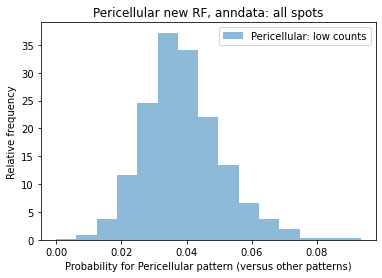

In [177]:
plt.hist(df_all_spots_new_model['prob_pattern'], bins=len(df_all_spots_new_model['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, anndata: all spots")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

### Old custom panel

In [11]:
adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [12]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata_mixed_cellID.obs['prop'] == 0.9) | ((adata_mixed_cellID.obs['prop'] == 0.4) & (adata_mixed_cellID.obs['pattern'] == 'protrusion')),
    (adata_mixed_cellID.obs['prop'] == 0.5) | ((adata_mixed_cellID.obs['prop'] == 0.2) & (adata_mixed_cellID.obs['pattern'] == 'protrusion')),
    (adata_mixed_cellID.obs['prop'] == 0.1) | ((adata_mixed_cellID.obs['prop'] == 0.0) & (adata_mixed_cellID.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata_mixed_cellID.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [147]:
pericellular_dict_mixed_cellID = subsetGenes(adata_mixed_cellID, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')

In [178]:
rows = []
patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
gene_id = np.array(range(10))

for pattern in patterns:
    for i in range(10):
        pericellular_mixed_cellID = models.get(pattern).predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,1]
        for value in pericellular_mixed_cellID:
            rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': pattern, 'gene_id': i})
df_test2 = pd.DataFrame(rows)

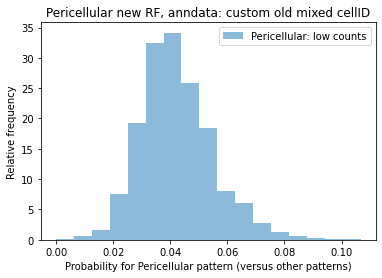

In [180]:
pattern = df_test2[(df_test2['RF_Classifier'] == 'pericellular') & (df_test2['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, anndata: custom old mixed cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Reproducing new data

In [150]:
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [151]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
conditions = [
    (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
    (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
]

choices = ['strong', 'intermediate', 'low']

adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [152]:
pericellular_dict_new = subsetGenes(adata, 'pericellular', pattern_strength = 0.9, count_threshold = 11, high_or_low = 'low')

In [181]:
rows = []
patterns = ['pattern', 'cellEdge', 'foci', 'extranuclear', 'intranuclear', 'nuclearEdge', 'pericellular', 'perinuclear', 'protrusion']
gene_id = np.array(range(10))

for pattern in patterns:
    for i in range(10):
        pericellular_new = models.get(pattern).predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,1]
        for value in pericellular_new:
            rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': pattern, 'gene_id': i})
df_new = pd.DataFrame(rows)

probably high cause included trained cases of my RF in these graphs

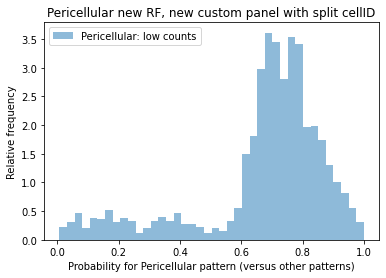

In [203]:
pattern = df_new[(df_new['RF_Classifier'] == 'pericellular') & (df_new['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, new custom panel with split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

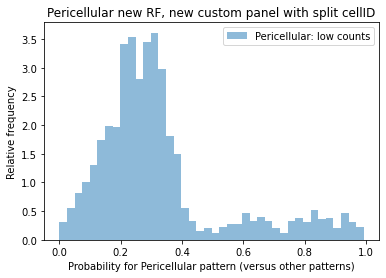

In [ ]:
pattern = df_new[(df_new['RF_Classifier'] == 'pericellular') & (df_new['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, new custom panel with split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Test old model see what comes out

In [157]:
import pickle

patterns = ['pericellular']

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        peri_model = pickle.load(p)

In [184]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    all_spots_old_rf = peri_model.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,1]
    for value in all_spots_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_old_model = pd.DataFrame(rows)

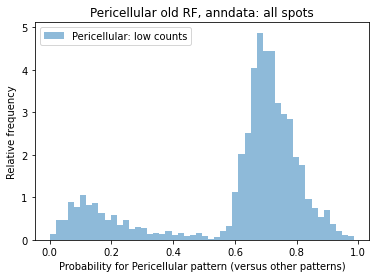

In [186]:
pattern = df_all_spots_old_model[(df_all_spots_old_model['RF_Classifier'] == 'pericellular') & (df_all_spots_old_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: all spots")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [187]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    mixed_cellID_old_rf = peri_model.predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,1]
    for value in mixed_cellID_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_mixed_cellID_new_model = pd.DataFrame(rows)

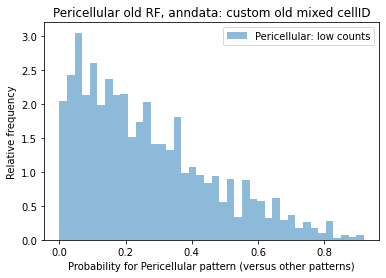

In [189]:
pattern = df_mixed_cellID_new_model[(df_mixed_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: custom old mixed cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

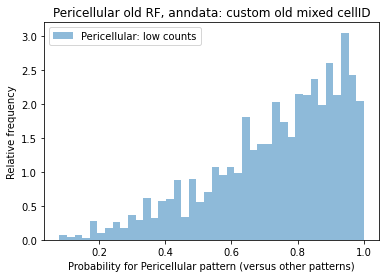

In [161]:
pattern = df_mixed_cellID_new_model[(df_mixed_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=40, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, anndata: custom old mixed cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [190]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    split_cellID_old_rf = peri_model.predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,1]
    for value in split_cellID_old_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_split_cellID_new_model = pd.DataFrame(rows)

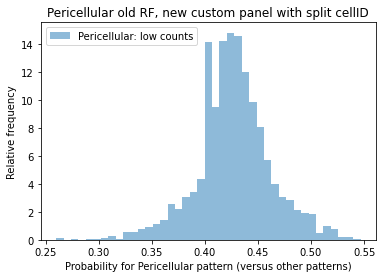

In [192]:
pattern = df_split_cellID_new_model[(df_split_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, new custom panel with split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

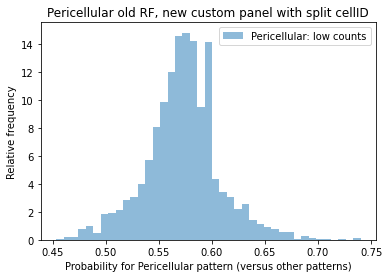

In [163]:
pattern = df_split_cellID_new_model[(df_split_cellID_new_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_new_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, new custom panel with split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Train pericellular binary RF including random to see if it is a bit more robust

In [184]:
adata_train.obs['pattern'].unique()

['cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'random', 'protrusion']
Categories (9, object): ['cell-edge', 'extranuclear', 'foci', 'intranuclear', ..., 'pericellular', 'perinuclear', 'protrusion', 'random']

In [185]:
adata_train.obs["pericellular"] = np.where(adata_train.obs["pattern"] == "pericellular", "pericellular", "other")
adata_test.obs["pericellular"] = np.where(adata_test.obs["pattern"] == "pericellular", "pericellular", "other")

<ipython-input-185-c1f34b7ebd3f>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs["pericellular"] = np.where(adata_train.obs["pattern"] == "pericellular", "pericellular", "other")
<ipython-input-185-c1f34b7ebd3f>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs["pericellular"] = np.where(adata_test.obs["pattern"] == "pericellular", "pericellular", "other")


In [187]:
 # create random forest classifier INCLUDING random
rf_pericellular = RandomForestClassifier(n_estimators=150, random_state=seed, max_features=4, bootstrap=True, oob_score=False)
rf_pericellular.fit(adata_train.obsm["latent"], adata_train.obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular.predict(adata_test.obsm["latent"])

print("f1 score: ", f1_score(adata_test.obs["pericellular"], test_pericellular, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(adata_test_pattern.obs["pericellular"], test_pericellular, pos_label='other'))

confusion_matrix = metrics.confusion_matrix(adata_test_pattern.obs["pericellular"], test_pericellular, labels = rf_pericellular.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_pericellular.classes_) 
cm_display.plot()
plt.show()

f1 score:  0.9846105404022514


NameError: name 'adata_test_pattern' is not defined

In [188]:
print("f1 score: ", f1_score(adata_test.obs["pericellular"], test_pericellular, pos_label='pericellular'))

f1 score:  0.9846105404022514


In [189]:
print("inverted f1 score: ", f1_score(adata_test.obs["pericellular"], test_pericellular, pos_label='other'))

inverted f1 score:  0.9979861865790408


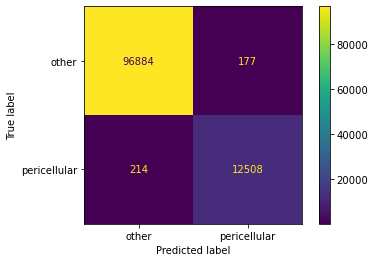

In [190]:
confusion_matrix = metrics.confusion_matrix(adata_test.obs["pericellular"], test_pericellular, labels = rf_pericellular.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = rf_pericellular.classes_) 
cm_display.plot()
plt.show()

In [216]:
import pickle

path = f"temp_objects/incl_random/rf_pericellular.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_pericellular, f)

In [164]:
import pickle

path = "temp_objects/incl_random/rf_pericellular.pkl"

# Open the file in read-binary mode and load the model
with open(path, 'rb') as p:
    rf_pericellular = pickle.load(p)

In [193]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    all_spots_random_rf = rf_pericellular.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,1]
    for value in all_spots_random_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_random_model = pd.DataFrame(rows)

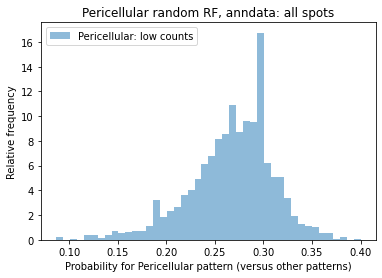

In [195]:
pattern = df_all_spots_random_model[(df_all_spots_random_model['RF_Classifier'] == 'pericellular') & (df_all_spots_random_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, anndata: all spots")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

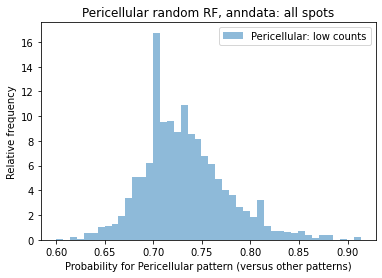

In [166]:
pattern = df_all_spots_random_model[(df_all_spots_random_model['RF_Classifier'] == 'pericellular') & (df_all_spots_random_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, anndata: all spots")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [196]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    mixed_cellID_random_rf = rf_pericellular.predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,1]
    for value in mixed_cellID_random_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_mixed_cellID_random_model = pd.DataFrame(rows)

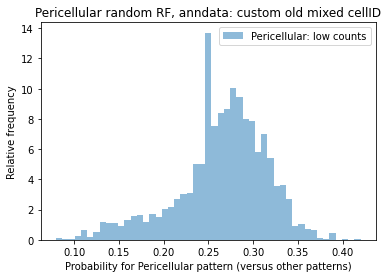

In [197]:
pattern = df_mixed_cellID_random_model[(df_mixed_cellID_random_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_random_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, anndata: custom old mixed cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [198]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    split_cellID_random_rf = rf_pericellular.predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,1]
    for value in split_cellID_random_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_split_cellID_random_model = pd.DataFrame(rows)

In [204]:
len(pattern['prob_pattern'].unique())

142

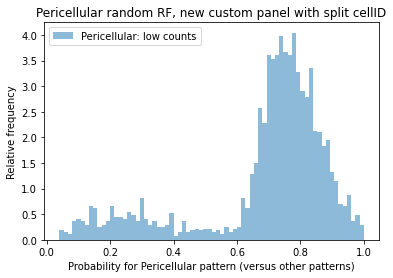

In [199]:
pattern = df_split_cellID_random_model[(df_split_cellID_random_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_random_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=72, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, new custom panel with split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

### Try with properly segregated test data for split cell ID

in the current version of splitcellID I have ~2040 datapoints. In the adata_test set there's only 507 elements that are pericellular, high pattern strength and count lower than 11. So will just use the entire test set iso dividing etc.

In [207]:
test = adata_test_pattern[adata_test_pattern.obs['pattern']=='pericellular']
pericellular_splitID_testset = test[test.obs['n_spots']<11]
#2040 current samplesize for split cellID

In [211]:
testsplit_cellID_random_rf = rf_pericellular.predict_proba(pericellular_splitID_testset.obsm["latent"])[:,1]

In [219]:
len(np.unique(testsplit_cellID_random_rf))

106

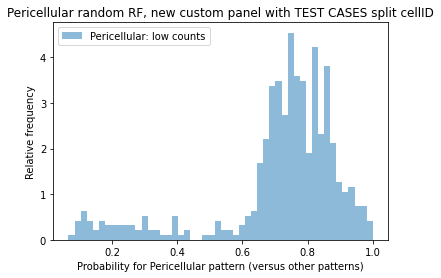

In [220]:

plt.hist(testsplit_cellID_random_rf, bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular random RF, new custom panel with TEST CASES split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [221]:
len(np.unique(testsplit_cellID_new_rf))

131

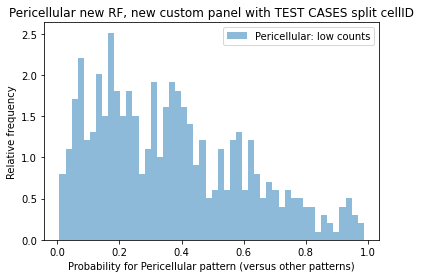

In [223]:
testsplit_cellID_new_rf = peri_model_splitID.predict_proba(pericellular_splitID_testset.obsm["latent"])[:,1]

plt.hist(testsplit_cellID_new_rf, bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular new RF, new custom panel with TEST CASES split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

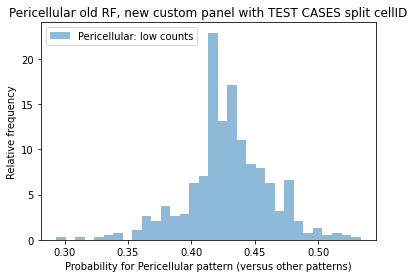

In [216]:
testsplit_cellID_old_rf = peri_model.predict_proba(pericellular_splitID_testset.obsm["latent"])[:,1]

plt.hist(testsplit_cellID_old_rf, bins=len(np.unique(testsplit_cellID_old_rf)), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular old RF, new custom panel with TEST CASES split cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

### KNN comparison

In [54]:
knn_classifier_pericellular_nonnormalized

KNeighborsClassifier(n_jobs=3, n_neighbors=69, weights='distance')

In [66]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    all_spots_knn_rf = knn_classifier_pericellular_nonnormalized.predict_proba(pericellular_dict_low_all.get(i).obsm["latent"])[:,0]
    for value in all_spots_knn_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_all_spots_knn_model = pd.DataFrame(rows)

In [39]:
df_all_spots_knn_model['prob_pattern'].value_counts()

1.0    2674
Name: prob_pattern, dtype: int64

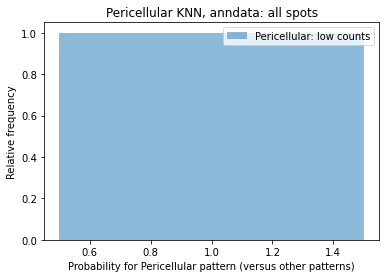

In [67]:
pattern = df_all_spots_knn_model[(df_all_spots_knn_model['RF_Classifier'] == 'pericellular') & (df_all_spots_knn_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular KNN, anndata: all spots")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [68]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    mixed_cellID_knn_rf = knn_classifier_pericellular_nonnormalized.predict_proba(pericellular_dict_mixed_cellID.get(i).obsm["latent"])[:,0]
    for value in mixed_cellID_knn_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_mixed_cellID_knn_model = pd.DataFrame(rows)

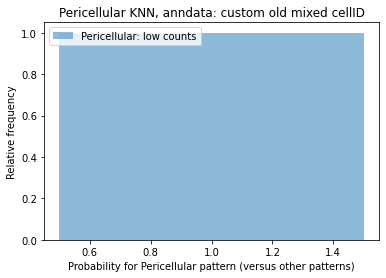

In [69]:
pattern = df_mixed_cellID_knn_model[(df_mixed_cellID_knn_model['RF_Classifier'] == 'pericellular') & (df_mixed_cellID_knn_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=len(pattern['prob_pattern'].unique()), alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular KNN, anndata: custom old mixed cellID")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [70]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    split_cellID_knn_rf = knn_classifier_pericellular_nonnormalized.predict_proba(pericellular_dict_new.get(i).obsm["latent"])[:,0]
    for value in split_cellID_knn_rf:
        rows.append({'prob_pattern': value, 'group': 'pericellular_low', 'RF_Classifier': 'pericellular', 'gene_id': i})
df_split_cellID_knn_model = pd.DataFrame(rows)

In [74]:
df_split_cellID_knn_model['prob_pattern'].value_counts()

0.000000    1611
1.000000      12
0.985327       1
0.971366       1
0.740218       1
            ... 
0.958818       1
0.645343       1
0.946070       1
0.984849       1
0.832062       1
Name: prob_pattern, Length: 419, dtype: int64

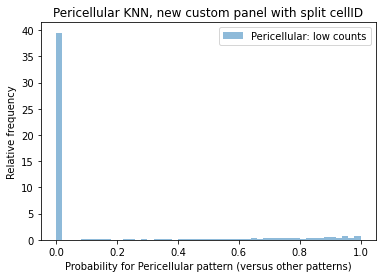

In [73]:
pattern = df_split_cellID_knn_model[(df_split_cellID_knn_model['RF_Classifier'] == 'pericellular') & (df_split_cellID_knn_model['group']=='pericellular_low')]
plt.hist(pattern['prob_pattern'], bins=50, alpha=0.5, label='Pericellular: low counts', density=True)

plt.title("Pericellular KNN, new custom panel with split cellID")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [ ]:
test_cellID_knn = knn_classifier_pericellular.predict_proba(test_ad.obsm["latent"])[:,0]

# K - nearest neighbours

Choice of k depends on the input data --> more outliers or noise performs better with a larger k (due to smoothing)

Recommended to have an odd number of k to avoid ties in classification. Use cross-validation to choose optimal k for the dataset.

Rule of thumb: choose a k close to the sqrt(datapoints), aka sqrt(176162)~419

Hyperparameter grid choice. Rule of thumb is that the sqrt(N) will work, and to use odd numbers. Therefore use sqrt as a center and 5 values above and below it. Given that 469 is a relatively large number, will first explore a larger space (i.e. 50 interval in between).

Based on [caching nearest neighbors - scikit-learn tutorial](https://scikit-learn.org/stable/auto_examples/neighbors/plot_caching_nearest_neighbors.html#sphx-glr-auto-examples-neighbors-plot-caching-nearest-neighbors-py) 

### Non-normalized KNN

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 1/5] END ........classifier__n_neighbors=69;, score=0.924 total time= 3.4min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 2/5] END ........classifier__n_neighbors=69;, score=0.928 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 3/5] END ........classifier__n_neighbors=69;, score=0.922 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 4/5] END ........classifier__n_neighbors=69;, score=0.921 total time= 3.3min


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV 5/5] END ........classifier__n_neighbors=69;, score=0.927 total time= 3.3min
[CV 1/5] END .......classifier__n_neighbors=119;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifier__n_neighbors=119;, score=0.927 total time=  38.6s
[CV 3/5] END .......classifier__n_neighbors=119;, score=0.922 total time=  38.9s
[CV 4/5] END .......classifier__n_neighbors=119;, score=0.920 total time=  39.4s
[CV 5/5] END .......classifier__n_neighbors=119;, score=0.927 total time=  38.9s
[CV 1/5] END .......classifier__n_neighbors=169;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifier__n_neighbors=169;, score=0.927 total time=  38.7s
[CV 3/5] END .......classifier__n_neighbors=169;, score=0.921 total time=  38.9s
[CV 4/5] END .......classifier__n_neighbors=169;, score=0.920 total time=  39.5s
[CV 5/5] END .......classifier__n_neighbors=169;, score=0.927 total time=  39.0s
[CV 1/5] END .......classifier__n_neighbors=219;, score=0.924 total time=  39.5s
[CV 2/5] END .......classifi

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 0.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


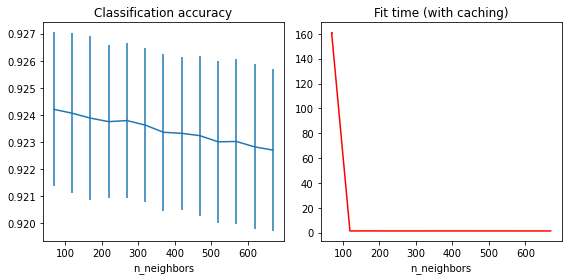

In [10]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

#X, y = load_digits(return_X_y=True)
n_neighbors_list = [69,119,169,219,269,319,369,419,469,519,569,619,669]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3)
    grid_model.fit(adata_train.obsm["latent"], adata_train.obs["random_or_pattern"])

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [70]:
knn_nonnormalized = grid_model.cv_results_
knn_nonnormalized

{'mean_fit_time': array([160.32603569,   1.36809492,   1.39574623,   1.36634436,
          1.364711  ,   1.36581612,   1.37345982,   1.36978893,
          1.366711  ,   1.3668128 ,   1.36542826,   1.36534615,
          1.36573067]),
 'std_fit_time': array([0.85542984, 0.00948896, 0.01288597, 0.01100495, 0.01349895,
        0.01014704, 0.00980585, 0.00822732, 0.01277583, 0.00950512,
        0.01184004, 0.00794088, 0.01065287]),
 'mean_score_time': array([39.81324239, 37.69407601, 37.71695495, 37.73753662, 37.74229832,
        37.76169548, 37.77588997, 37.80055475, 37.80514007, 37.82576494,
        37.88281603, 37.9218977 , 37.94148393]),
 'std_score_time': array([0.66837186, 0.33251339, 0.33180792, 0.33658414, 0.33296387,
        0.33259267, 0.32914207, 0.33045184, 0.33654874, 0.33934595,
        0.31766483, 0.34116603, 0.33493058]),
 'param_classifier__n_neighbors': masked_array(data=[69, 119, 169, 219, 269, 319, 369, 419, 469, 519, 569,
                    619, 669],
              mas

#### Save and load the KNN object 
So that I don't have to rerun it later, and can just get the object to make vizualiations / multiplots. 

In [61]:
np.savez('knn_nonnormalized.npz', **knn_nonnormalized)

In [69]:
load_dict = dict(np.load('knn_nonnormalized.npz', allow_pickle=True))

Text(0.5, 1.0, 'Grid Search Results Non-Normalized Latent Space')

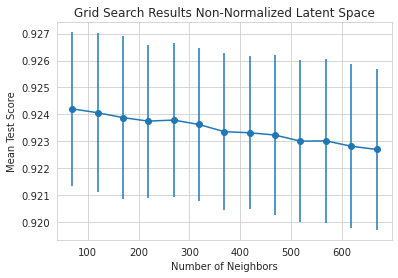

In [68]:
# Code to run the plot from the saved object. The x axis is a bit difficult to get cause it's a masked array, that's why it looks weird
fig, ax = plt.subplots()
ax.errorbar(load_dict.get("param_classifier__n_neighbors").compressed(), load_dict["mean_test_score"], yerr=load_dict['std_test_score'], fmt='-o')
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Mean Test Score")
ax.set_title("Grid Search Results Non-Normalized Latent Space")

Text(0.5, 1.0, 'Grid Search Results')

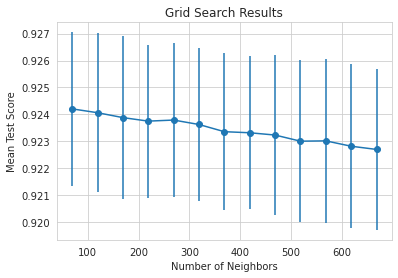

In [22]:
fig, ax = plt.subplots()
ax.errorbar(n_neighbors_list, grid_model.cv_results_["mean_test_score"], yerr=grid_model.cv_results_['std_test_score'], fmt='-o')
ax.set_xlabel("Number of Neighbors")
ax.set_ylabel("Mean Test Score")
ax.set_title("Grid Search Results Non-Normalized Latent Space")

### Normalized KNN

In [7]:
from scipy import stats
stats.normaltest(adata.obsm['latent'], axis=0)

NormaltestResult(statistic=array([6.0259956e+05, 3.7095406e+04, 4.1652419e+05, 3.1404624e+03,
       1.9232203e+05, 9.3925289e+04, 2.1567359e+05, 7.3154297e+04,
       5.2818794e+05, 1.2615511e+02, 1.6465244e+05, 4.2915634e+05,
       7.1508544e+05, 7.3119219e+04, 4.9107637e+04], dtype=float32), pvalue=array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.03427252e-28, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]))

normalizing the dimensions and see if that influences the accuracy. Given that none of the latent dimensions are normally distributed, nor are they multivariate normally distributed, we will normalize the latent dimensions using min-max normalization rather than standardization (which assumes the data to be normally distributed)

In [71]:
adata_train2 = adata_train.copy()


In [10]:
adata_train_labels = adata_train.copy()
scaler = MinMaxScaler()
adata_train_labels.obsm['latent']=scaler.fit_transform(adata_train_labels.obsm['latent'])
adata_train_labels.obsm['latent']
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [9]:
adata_train_labels

AnnData object with n_obs × n_vars = 432577 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    uns: 'test_cellIDs', 'train_cellIDs'
    obsm: 'latent'

In [10]:
np.sqrt(432577)

657.7058613088377

In [11]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]
n_neighbors_list = [69,119,169,219,269,319,369,419,469,519,569,619,669]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='f1', error_score='raise', n_jobs=-1)
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

Fitting 5 folds for each of 13 candidates, totalling 65 fits


In [74]:
knn_normalized = grid_model.cv_results_
np.savez('knn_normalized.npz', **knn_normalized)

In [75]:
print(grid_model.best_params_)
grid_model.best_score_

{'classifier__n_neighbors': 69}


0.9468950007408262

# Binary RF Pericellular

In [49]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_test_pattern = adata_test.copy()
adata_test_pattern = adata_test_pattern[adata_test_pattern.obs['pattern']!='random']
adata_train_pattern.obs["pericellular"] = np.where(adata_train_pattern.obs["pattern"] == "pericellular", "pericellular", "other")
adata_test_pattern.obs["pericellular"] = np.where(adata_test_pattern.obs["pattern"] == "pericellular", "pericellular", "other")


<ipython-input-49-30aff38b7d04>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_pattern.obs["pericellular"] = np.where(adata_train_pattern.obs["pattern"] == "pericellular", "pericellular", "other")
<ipython-input-49-30aff38b7d04>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_pattern.obs["pericellular"] = np.where(adata_test_pattern.obs["pattern"] == "pericellular", "pericellular", "other")


In [50]:
adata_train_labels = adata_train_pattern.copy()
scaler = MinMaxScaler()
adata_train_labels.obsm['latent']=scaler.fit_transform(adata_train_labels.obsm['latent'])
adata_train_labels.obsm['latent']


array([[0.6327063 , 0.6642418 , 0.7665824 , ..., 0.74734914, 0.5134743 ,
        0.57353896],
       [0.6186733 , 0.6164652 , 0.6824496 , ..., 0.75371945, 0.56785315,
        0.504585  ],
       [0.58421314, 0.61635643, 0.6993158 , ..., 0.7349448 , 0.5494817 ,
        0.60016423],
       ...,
       [0.6187626 , 0.56264997, 0.6759554 , ..., 0.8045574 , 0.7477463 ,
        0.74357915],
       [0.6512229 , 0.47690317, 0.57371545, ..., 0.8366841 , 0.68739927,
        0.77532417],
       [0.57837766, 0.5499843 , 0.64735866, ..., 0.7445142 , 0.75865227,
        0.76303697]], dtype=float32)

In [ ]:
pattern_mapping = {'pericellular': 1, 'other': 0}
adata_train_labels.obs['pericellular'].replace(pattern_mapping, inplace=True)

In [13]:
adata_train_labels.obs['pattern_strength'].unique()

array(['strong'], dtype=object)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/sklearn/pipeline.py:336: UserWarning: Persisting input arguments took 1.36s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


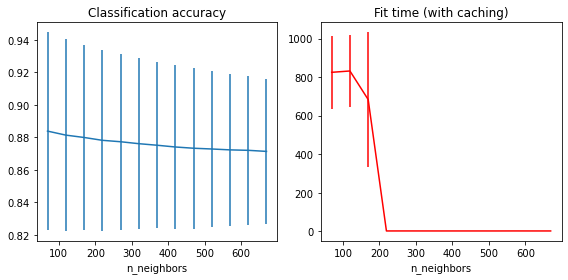

In [15]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["pericellular"]
n_neighbors_list = [69,119,169,219,269,319,369,419,469,519,569,619,669]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='f1', error_score='raise', n_jobs=13)
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [16]:
grid_model

GridSearchCV(error_score='raise',
             estimator=Pipeline(memory='/tmp/sklearn_graph_cache_4upi2a7o',
                                steps=[('graph',
                                        KNeighborsTransformer(n_neighbors=669)),
                                       ('classifier',
                                        KNeighborsClassifier(metric='precomputed'))]),
             n_jobs=13,
             param_grid={'classifier__n_neighbors': [69, 119, 169, 219, 269,
                                                     319, 369, 419, 469, 519,
                                                     569, 619, 669]},
             scoring='f1', verbose=3)

In [95]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_test_pattern = adata_test.copy()
adata_test_pattern = adata_test_pattern[adata_test_pattern.obs['pattern']!='random']
adata_train_pattern.obs["pericellular"] = np.where(adata_train_pattern.obs["pattern"] == "pericellular", "pericellular", "other")
adata_test_pattern.obs["pericellular"] = np.where(adata_test_pattern.obs["pattern"] == "pericellular", "pericellular", "other")

<ipython-input-95-30aff38b7d04>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train_pattern.obs["pericellular"] = np.where(adata_train_pattern.obs["pattern"] == "pericellular", "pericellular", "other")
<ipython-input-95-30aff38b7d04>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_pattern.obs["pericellular"] = np.where(adata_test_pattern.obs["pattern"] == "pericellular", "pericellular", "other")


In [93]:
knn_classifier_pericellular_nonnormalized = KNeighborsClassifier(n_neighbors = 69, weights = 'distance', n_jobs = 3)

In [96]:
adata_train_pattern.obs["pericellular"]

10         other
11         other
12         other
13         other
14         other
           ...  
1437909    other
1437910    other
1437911    other
1437912    other
1437913    other
Name: pericellular, Length: 382233, dtype: object

In [97]:
knn_classifier_pericellular_nonnormalized.fit(adata_train_pattern.obsm["latent"], adata_train_pattern.obs["pericellular"])

KNeighborsClassifier(n_jobs=3, n_neighbors=69, weights='distance')

In [53]:
import pickle

path = f"temp_objects/knn/rf_mixed_cellID_pericellular_nonnormalized.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(knn_classifier_pericellular_nonnormalized, f)

In [98]:
test = knn_classifier_pericellular_nonnormalized.predict_proba(adata_test_pattern.obsm["latent"])
test # first column = other, second column = pericellular

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [0.96965622, 0.03034378],
       [1.        , 0.        ]])

In [99]:
adata_test_pattern.obs['test'] = test[:,1]

In [81]:
adata_test_pattern.obs['pericellular'].value_counts()

0    84329
1    12722
Name: pericellular, dtype: int64

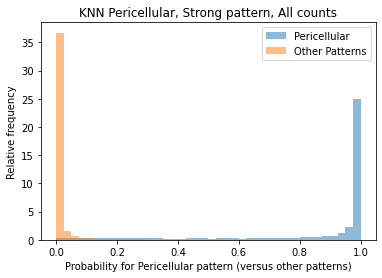

In [225]:
pericellular = adata_test_pattern[adata_test_pattern.obs['pericellular']=='pericellular']
other = adata_test_pattern[adata_test_pattern.obs['pericellular']=='other']

plt.hist(pericellular.obs['test'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(other.obs['test'], bins=40, alpha=0.5, label='Other Patterns', density=True)
#plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title("KNN Pericellular, Strong pattern, All counts")
plt.xlabel('')
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

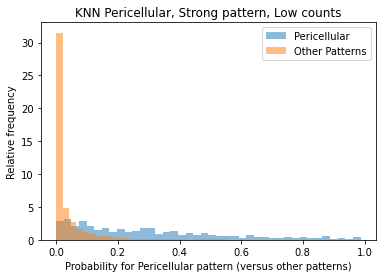

In [226]:
adata_test_low = adata_test_pattern[adata_test_pattern.obs['n_spots']<11]
pericellular = adata_test_low[adata_test_low.obs['pericellular']=='pericellular']
other = adata_test_low[adata_test_low.obs['pericellular']=='other']

plt.hist(pericellular.obs['test'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(other.obs['test'], bins=40, alpha=0.5, label='Other Patterns', density=True)
#plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title("KNN Pericellular, Strong pattern, Low counts")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

# RF Histogram prediction all low counts

In [10]:
import pickle

patterns = ['pericellular']

for pattern in patterns:
    # Specify the path where the model is saved
    path = f"temp_objects/f1_negative_cellID_split/rf_{pattern}.pkl"

    # Open the file in read-binary mode and load the model
    with open(path, 'rb') as p:
        peri_model = pickle.load(p)

In [86]:
peri_test = peri_model.predict_proba(adata_test_pattern.obsm["latent"])


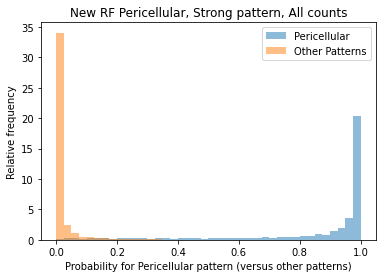

In [227]:
adata_test_pattern.obs['test_rf_splitID'] = peri_test[:,1]
pericellular = adata_test_pattern[adata_test_pattern.obs['pericellular']=='pericellular']
other = adata_test_pattern[adata_test_pattern.obs['pericellular']=='other']

plt.hist(pericellular.obs['test_rf_splitID'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(other.obs['test_rf_splitID'], bins=40, alpha=0.5, label='Other Patterns', density=True)
#plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title("New RF Pericellular, Strong pattern, All counts")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

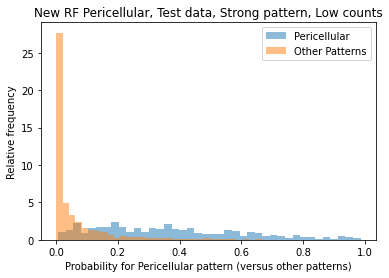

In [229]:
adata_test_low = adata_test_pattern[adata_test_pattern.obs['n_spots']<11]
pericellular = adata_test_low[adata_test_low.obs['pericellular']=='pericellular']
other = adata_test_low[adata_test_low.obs['pericellular']=='other']

plt.hist(pericellular.obs['test_rf_splitID'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(other.obs['test_rf_splitID'], bins=40, alpha=0.5, label='Other Patterns', density=True)
#plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title("New RF Pericellular, Test data, Strong pattern, Low counts")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Different data

## Custom panel, mixed cellID

In [13]:
adata_mixed_cellID[adata_mixed_cellID['pattern_strength']=='strong']

KeyError: 'pattern_strength'

In [ ]:
adata_test_pattern.obs['test_rf_splitID'] = peri_test[:,1]
pericellular = adata_test_pattern[adata_test_pattern.obs['pericellular']=='pericellular']
other = adata_test_pattern[adata_test_pattern.obs['pericellular']=='other']

plt.hist(pericellular.obs['test_rf_splitID'], bins=40, alpha=0.5, label='Pericellular', density=True)
plt.hist(other.obs['test_rf_splitID'], bins=40, alpha=0.5, label='Other Patterns', density=True)
#plt.hist(random_low['prob_pattern'], bins=40, alpha=0.5, label='Random: low counts', density=True)

plt.title("New RF Pericellular, Strong pattern, All counts")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pericellular pattern (versus other patterns)")
plt.ylabel("Relative frequency")
plt.show()

## Multi-class KNN

Hyperparameter grid around sqrt(157654)~355

In [10]:
adata_train_pattern = adata_train.copy()
adata_train_pattern = adata_train_pattern[adata_train_pattern.obs['pattern']!='random']
adata_test_pattern = adata_val.copy()
adata_test_pattern = adata_test_pattern[adata_test_pattern.obs['pattern']!='random']
#pattern_mapping = {'pattern': 1, 'random': 0}
#adata_train_labels.obs['random_or_pattern'].replace(pattern_mapping, inplace=True)

In [11]:
adata_train_pattern.obs

,pattern,random_or_pattern,n_spots,n_spots_interval,cell_id,genes,rotation,rotation_interval,blur,blur_interval,...,pattern_classified,cell-edge,extranuclear,intranuclear,pericellular,perinuclear,random,random_score,pattern_score,batch
663,cell-edge,pattern,81,90-100,27,blank,307,300+,1.5,NaN,...,cell-edge,0.992096,0.934968,5.487039e-15,1.322831e-10,0.000015,0.967630,0.392781,0.608507,0
664,cell-edge,pattern,81,90-100,27,blank,45,0-60,1.5,NaN,...,extranuclear,0.754152,0.798077,2.422030e-14,2.009141e-09,0.000235,0.627178,0.244180,0.757463,0
665,cell-edge,pattern,81,90-100,27,blank,90,60-120,1.5,NaN,...,cell-edge,0.999964,0.999141,8.410337e-18,1.347031e-07,0.000001,0.035344,0.089089,0.911159,0
897,cell-edge,pattern,24,20-30,27,blank,251,240-300,1.5,NaN,...,random,0.972466,0.127212,2.169975e-11,1.990620e-15,0.000403,1.000000,0.983680,0.016362,0
898,cell-edge,pattern,24,20-30,27,blank,65,60-120,1.5,NaN,...,random,0.004701,0.000760,6.626342e-10,3.418462e-15,0.003140,1.000000,0.945318,0.054801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156222,perinuclear,pattern,27,20-30,108,blank,251,240-300,1.5,NaN,...,perinuclear,0.032426,0.723309,1.660171e-07,1.175373e-04,0.996019,0.033108,0.110164,0.890005,0
156223,perinuclear,pattern,27,20-30,108,blank,332,300+,1.5,NaN,...,extranuclear,0.502149,0.634688,1.423556e-07,4.383508e-05,0.488439,0.412596,0.169994,0.829664,0
156868,perinuclear,pattern,11,10-20,108,blank,100,60-120,1.5,NaN,...,random,0.013130,0.017682,1.378627e-05,2.662874e-08,0.974515,0.998928,0.599384,0.400611,0
156869,perinuclear,pattern,11,10-20,108,blank,168,120-180,1.5,NaN,...,random,0.059709,0.001133,3.874913e-04,1.750608e-06,0.153743,0.999459,0.706572,0.294269,0


In [16]:
adata_train_pattern.obsm['latent']

ArrayView([[-0.3208191 ,  2.8225806 , -1.3590801 , ..., -5.384647  ,
            -8.265151  ,  5.773748  ],
           [-0.40570036,  2.9171438 , -0.9277612 , ..., -5.3958044 ,
            -7.8791065 ,  5.4216666 ],
           [-0.97488296,  3.6805127 , -1.9317566 , ..., -5.5002418 ,
            -7.7567444 ,  5.3031464 ],
           ...,
           [ 2.6768274 ,  2.9809794 , -2.6266003 , ..., -4.2222443 ,
            -7.9422026 ,  7.013573  ],
           [ 1.7666696 ,  2.5898604 , -1.8280711 , ..., -2.933899  ,
            -6.9415245 ,  6.9567447 ],
           [ 1.7096524 ,  2.0780938 , -1.8532205 , ..., -3.107962  ,
            -6.902675  ,  6.38632   ]], dtype=float32)

In [24]:
np.sqrt(125852)

354.7562543493772

We use average='macro', which calculate the F1 score over all the classes, which we do because all patterns have an equal amount of observations, so there is no class imbalance.

In [17]:
scaler = MinMaxScaler()
adata_train_pattern.obsm['latent']=scaler.fit_transform(adata_train_pattern.obsm['latent'])
adata_train_pattern.obsm['latent']

array([[0.5566338 , 0.37366953, 0.31004786, ..., 0.7680447 , 0.387528  ,
        0.34089357],
       [0.5494416 , 0.38041553, 0.3482966 , ..., 0.7675096 , 0.41180426,
        0.30852818],
       [0.5012134 , 0.43487304, 0.2592637 , ..., 0.7625008 , 0.41949895,
        0.2976331 ],
       ...,
       [0.8106315 , 0.38496947, 0.19764595, ..., 0.8237932 , 0.4078365 ,
        0.45486546],
       [0.7335117 , 0.35706764, 0.26845837, ..., 0.88558185, 0.47076374,
        0.44964147],
       [0.7286805 , 0.32055902, 0.2662282 , ..., 0.87723386, 0.47320676,
        0.39720476]], dtype=float32)

In [ ]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_pattern.obsm["latent"]
labels = adata_train_pattern.obs["pattern"]
n_neighbors_list = [55,105,155,205,255,305,355,405,455,505,555,605,655]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='f1_macro', error_score='raise')
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

In [20]:
knn_pattern = grid_model.cv_results_
np.savez('knn_patterns.npz', **knn_pattern)